In [9]:
# Библиотеки
import math
import random
import matplotlib.pyplot as plt

In [10]:
# Загрузка данных
def load_csv(filename):
    data = []
    with open(filename, encoding="utf-8") as f:
        lines = f.readlines()

    lines = lines[1:]   # Пропускаем заголовки

    for line in lines:
        line = line.strip()
        if line == "":
            continue
        row = list(map(float, line.split(";")))
        data.append(row)
    return data

In [11]:
# Евклидово расстояние
def euclidean_distance(a, b):
    dist = 0
    for i in range(len(a)):
        dist += (a[i] - b[i]) ** 2
    return math.sqrt(dist)

In [12]:
# Разделение на train/test
def train_test_split(data, test_size=0.3):
    random.shuffle(data)
    split = int(len(data) * (1 - test_size))
    return data[:split], data[split:]

In [13]:
# KNN
def knn_predict(train, test_row, k):
    distances = []
    for train_row in train:
        dist = euclidean_distance(test_row[1:], train_row[1:])
        distances.append((dist, train_row[0]))

    distances.sort(key=lambda x: x[0])
    neighbors = [label for (_, label) in distances[:k]]  # берём метки k ближайших
    prediction = max(set(neighbors), key=neighbors.count)  # определяем наиболее частую метку
    return prediction

In [14]:
# Оценка точности
def accuracy(train, test, k):
    correct = 0
    for row in test:
        y_true = row[0]
        y_pred = knn_predict(train, row, k)
        if y_true == y_pred:
            correct += 1
    return correct / len(test)

In [15]:
# Анализ — какое k лучше (усреднение по нескольким запускам)
def find_best_k(data, max_k=10, runs=5):
    avg_results = {k: 0 for k in range(1, max_k + 1)}

    for r in range(runs):
        train, test = train_test_split(data, test_size=0.3)
        for k in range(1, max_k + 1):
            acc = accuracy(train, test, k)
            avg_results[k] += acc

    # усредняем
    for k in avg_results:
        avg_results[k] /= runs

    # выводим результаты
    for k, acc in avg_results.items():
        print(f"k={k}, средняя accuracy={acc:.2f}")

    best_k = max(avg_results, key=avg_results.get)
    print(f"Лучшее k: {best_k}, средняя точность: {avg_results[best_k]:.2f}")

    # график
    ks = list(avg_results.keys())
    accs = list(avg_results.values())

    plt.figure(figsize=(8, 5))
    plt.plot(ks, accs, marker='o')
    plt.xlabel('k (число соседей)')
    plt.ylabel('Средняя точность')
    plt.title(f'Средняя точность от k (усреднено по {runs} запускам)')
    plt.grid(True)
    plt.show()

    return best_k

Размер выборки: 33
k=1, средняя accuracy=0.66
k=2, средняя accuracy=0.68
k=3, средняя accuracy=0.66
k=4, средняя accuracy=0.68
k=5, средняя accuracy=0.69
k=6, средняя accuracy=0.64
k=7, средняя accuracy=0.68
k=8, средняя accuracy=0.66
k=9, средняя accuracy=0.70
k=10, средняя accuracy=0.70
k=11, средняя accuracy=0.69
k=12, средняя accuracy=0.68
k=13, средняя accuracy=0.65
k=14, средняя accuracy=0.64
k=15, средняя accuracy=0.60
Лучшее k: 9, средняя точность: 0.70


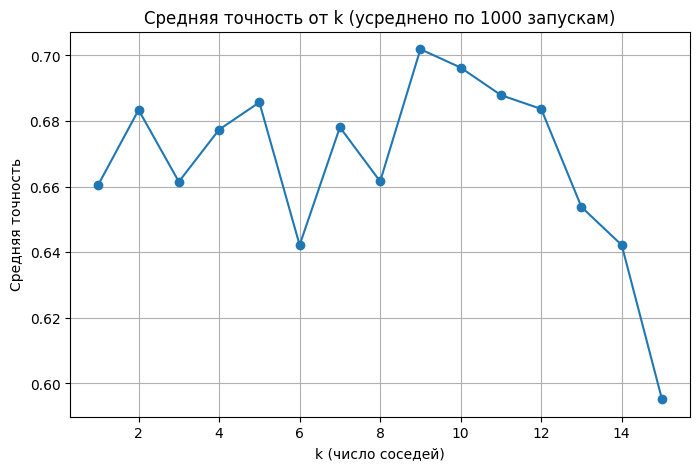

Примеры предсказаний:
Реально: 2 Предсказано: 2
Реально: 1 Предсказано: 2
Реально: 2 Предсказано: 2
Реально: 2 Предсказано: 2
Реально: 2 Предсказано: 2


In [16]:
# Запуск

filename = "data.csv"
data = load_csv(filename)

print("Размер выборки:", len(data))

best_k = find_best_k(data, max_k=15, runs=1000)

# итоговое тестирование на одном запуске с best_k
train, test = train_test_split(data, test_size=0.3)
print("Примеры предсказаний:")
for row in test[:5]:
    print("Реально:", int(row[0]), "Предсказано:", int(knn_predict(train, row, best_k)))